In [1]:
using UMAP: umap
using MLDatasets
using VegaLite
using DataFrames
using OptimalTransport
# using Tulip
using Distances
using LinearAlgebra
using CSV
using JLD2
using CUDA

In [2]:
x = MNIST.traintensor(Float64)
mnist_x = reshape(x, 28*28, :);
mnist_y = MNIST.trainlabels(1:size(mnist_x, 2));

normalize_mnist(x) = mnist_x[:,x] / sum(mnist_x[:,x])
norm_mnist_x = normalize_mnist.(1:length(mnist_x[1,:]));

In [3]:
res_jl = umap(mnist_x[:,1:5000]; n_neighbors=10, min_dist=0.001, n_epochs=200)

2×5000 Matrix{Float64}:
 -2.94499  -8.33519  3.57737   5.16878  …   0.709784   2.92313   1.47898
  1.24301   3.14703  4.61467  -4.59796     -4.29593   -5.99067  -4.14464

In [4]:
df = DataFrame(
    x1    = res_jl'[:,1],
    x2    = res_jl'[:,2],
    label = mnist_y[1:size(res_jl)[2]]);

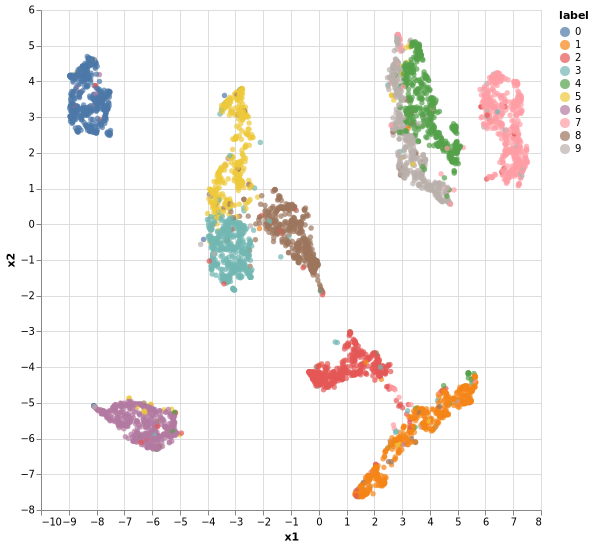

In [5]:
@vlplot(data=df,:circle,x={:x1},y={:x2},color={:label, type="nominal"},height=500,width=500)

In [20]:
N = 5000
n = 28
nonzero = []
for i in norm_mnist_x
    push!(nonzero,findall(!iszero,i))
end
distm = collect(Iterators.product(1:n,1:n));
μ = reshape(distm,n*n);
ν = reshape(distm,n*n);
@time jldopen("mnist_distances_sinkhorn10.jld2", "w+") do file
    Threads.@threads for i in 1:N
        D = zeros(N)
        for j in i+1:N
            u = norm_mnist_x[i]
            v = norm_mnist_x[j]
            C = float.(pairwise(SqEuclidean(), μ[nonzero[i]], ν[nonzero[j]]))
            u = u[nonzero[i]]
            v = v[nonzero[j]]
            D[j] = sinkhorn2(u,v,C,10)
        end
        file["row"*string(i)] = D
    end
end

┌ Warning: Sinkhorn algorithm did not converge
└ @ OptimalTransport /home/davibarreira/.julia/packages/OptimalTransport/QINz7/src/OptimalTransport.jl:180
┌ Warning: Sinkhorn algorithm did not converge
└ @ OptimalTransport /home/davibarreira/.julia/packages/OptimalTransport/QINz7/src/OptimalTransport.jl:180
┌ Warning: Sinkhorn algorithm did not converge
└ @ OptimalTransport /home/davibarreira/.julia/packages/OptimalTransport/QINz7/src/OptimalTransport.jl:180


24420.949407 seconds (430.23 M allocations: 10.339 TiB, 0.45% gc time, 0.00% compilation time)


In [30]:
D = UpperTriangular(zeros(N,N))
jldopen("mnist_distances_sinkhorn10.jld2", "r") do file
    for i in 1:N
        D[i,:] = file["row"*string(i)]
    end
end

In [31]:
Dfull = Symmetric(D);

In [33]:
res_jl = umap(Dfull, 2; metric=:precomputed, n_neighbors=10, min_dist=0.001, n_epochs=200)

2×5000 Matrix{Float64}:
 -1.07517   3.63683  4.00623  -11.079    …   1.28551  -10.0046     1.47652
 -2.4466   -9.58303  5.20871   -1.66082     -1.92645    0.463442  -1.56436

In [34]:
df = DataFrame(
    x1    = res_jl'[:,1],
    x2    = res_jl'[:,2],
    label = mnist_y[1:size(res_jl)[2]]);

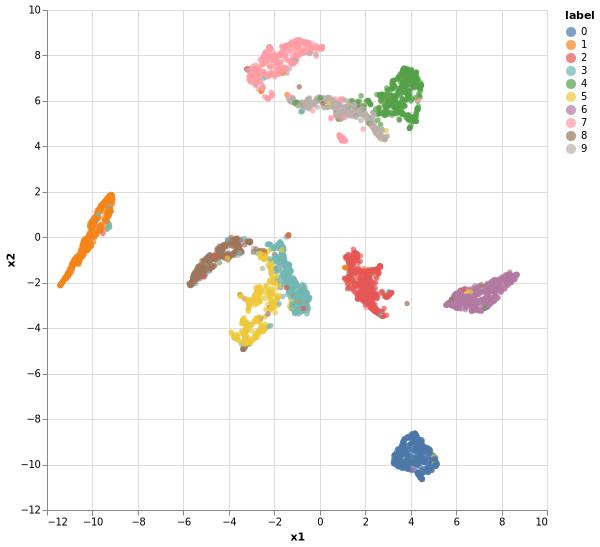

In [35]:
@vlplot(data=df,:circle,x={:x1},y={:x2},color={:label, type="nominal"},height=500,width=500)

# CUDA

In [14]:
N = 2
n = 28
i = 1
j = 2
distm = collect(Iterators.product(1:n,1:n));
μ = reshape(distm,n*n)
ν = reshape(distm,n*n)
μ = hcat([[float(i[1]),float(i[2])] for i in μ]...);
ν = hcat([[float(i[1]),float(i[2])] for i in ν]...);

In [15]:
μc = CuArray(μ)
νc = CuArray(ν)
X  = CuArray(hcat(norm_mnist_x...));
D = CUDA.zeros(N)

2-element CuArray{Float32, 1}:
 0.0
 0.0

In [18]:
u = X[:,1:2]
v = X[:,1:2]

784×2 CuArray{Float64, 2}:
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 ⋮    
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0

In [27]:
function cudadist!(D,μc,νc,X)
    index = threadIdx().x
    for j = index:N
#         @inbounds u = X[:,index]
#         @inbounds v = X[:,j]
#         C = pairwise(SqEuclidean(),μc[:,findall(!iszero,u)],νc[:,findall(!iszero,v)])
#         us=u[findall(!iszero,u)]
#         vs=v[findall(!iszero,v)]
#         @inbounds D[j] = sinkhorn2(us,vs,C,10)
        D[j] = 1.0
    end
end

cudadist! (generic function with 1 method)

In [29]:
@cuda threads=2 cudadist!(D,μc,νc,X)

LoadError: InvalidIRError: compiling kernel cudadist!(CuDeviceVector{Float32, 1}, CuDeviceMatrix{Float64, 1}, CuDeviceMatrix{Float64, 1}, CuDeviceMatrix{Float64, 1}) resulted in invalid LLVM IR
Reason: unsupported dynamic function invocation (call to typename(a::DataType) in Base at essentials.jl:304)
Stacktrace:
 [1] [0m[1m_unaliascopy[22m
[90m   @ [39m[90;4mabstractarray.jl:1368[0m
 [2] [0m[1munaliascopy[22m
[90m   @ [39m[90;4mabstractarray.jl:1366[0m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90;4munknown:0[0m
Reason: unsupported call to the Julia runtime (call to jl_object_id_)
Stacktrace:
 [1] [0m[1mobjectid[22m
[90m   @ [39m[90;4mreflection.jl:291[0m
 [2] [0m[1mdataids[22m
[90m   @ [39m[90;4mabstractarray.jl:1407[0m
 [3] [0m[1mmightalias[22m
[90m   @ [39m[90;4mabstractarray.jl:1384[0m
 [4] [0m[1munalias[22m
[90m   @ [39m[90;4mabstractarray.jl:1349[0m
 [5] [0m[1mcopyto![22m
[90m   @ [39m[90;4mabstractarray.jl:949[0m
 [6] [0m[1mcopymutable[22m
[90m   @ [39m[90;4mabstractarray.jl:1081[0m
 [7] [0m[1mcopy[22m
[90m   @ [39m[90;4mabstractarray.jl:1025[0m
 [8] [0m[1munaliascopy[22m
[90m   @ [39m[90;4mabstractarray.jl:1366[0m
 [9] [0m[1mmultiple call sites[22m
[90m   @ [39m[90;4munknown:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
 [1] [0m[1mArray[22m
[90m   @ [39m[90;4mboot.jl:448[0m
 [2] [0m[1mArray[22m
[90m   @ [39m[90;4mboot.jl:457[0m
 [3] [0m[1msimilar[22m
[90m   @ [39m[90;4mabstractarray.jl:750[0m
 [4] [0m[1msimilar[22m
[90m   @ [39m[90;4mabstractarray.jl:739[0m
 [5] [0m[1msimilar[22m
[90m   @ [39m[90;4mabstractarray.jl:738[0m
 [6] [0m[1mcopymutable[22m
[90m   @ [39m[90;4mabstractarray.jl:1081[0m
 [7] [0m[1mcopy[22m
[90m   @ [39m[90;4mabstractarray.jl:1025[0m
 [8] [0m[1munaliascopy[22m
[90m   @ [39m[90;4mabstractarray.jl:1366[0m
 [9] [0m[1mmultiple call sites[22m
[90m   @ [39m[90;4munknown:0[0m
Reason: unsupported call to the Julia runtime (call to jl_object_id_)
Stacktrace:
 [1] [0m[1mobjectid[22m
[90m   @ [39m[90;4mreflection.jl:291[0m
 [2] [0m[1mdataids[22m
[90m   @ [39m[90;4mabstractarray.jl:1407[0m
 [3] [0m[1mmightalias[22m
[90m   @ [39m[90;4mabstractarray.jl:1384[0m
 [4] [0m[1munalias[22m
[90m   @ [39m[90;4mabstractarray.jl:1349[0m
 [5] [0m[1m_unsafe_setindex![22m
[90m   @ [39m[90;4mmultidimensional.jl:894[0m
 [6] [0m[1m_setindex![22m
[90m   @ [39m[90;4mmultidimensional.jl:887[0m
 [7] [0m[1msetindex![22m
[90m   @ [39m[90;4mabstractarray.jl:1267[0m
 [8] [0m[1msetindex![22m
[90m   @ [39m[90m~/.julia/packages/FillArrays/tE9Xq/src/[39m[90;4mtrues.jl:34[0m
 [9] [0m[1mcudadist![22m
[90m   @ [39m[90;4mIn[27]:10[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
 [1] [0m[1mArray[22m
[90m   @ [39m[90;4mboot.jl:448[0m
 [2] [0m[1mBitArray[22m
[90m   @ [39m[90;4mbitarray.jl:37[0m
 [3] [0m[1mBitArray[22m
[90m   @ [39m[90;4mbitarray.jl:71[0m
 [4] [0m[1mtrues[22m
[90m   @ [39m[90;4mbitarray.jl:423[0m
 [5] [0m[1msetindex![22m
[90m   @ [39m[90m~/.julia/packages/FillArrays/tE9Xq/src/[39m[90;4mtrues.jl:34[0m
 [6] [0m[1mcudadist![22m
[90m   @ [39m[90;4mIn[27]:10[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
 [1] [0m[1m_string_n[22m
[90m   @ [39m[90mstrings/[39m[90;4mstring.jl:74[0m
 [2] [0m[1mStringVector[22m
[90m   @ [39m[90;4miobuffer.jl:31[0m
 [3] [0m[1m#IOBuffer#361[22m
[90m   @ [39m[90;4miobuffer.jl:114[0m
 [4] [0m[1mprint_to_string[22m
[90m   @ [39m[90mstrings/[39m[90;4mio.jl:133[0m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90;4munknown:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
 [1] [0m[1munsafe_wrap[22m
[90m   @ [39m[90mstrings/[39m[90;4mstring.jl:85[0m
 [2] [0m[1mStringVector[22m
[90m   @ [39m[90;4miobuffer.jl:31[0m
 [3] [0m[1m#IOBuffer#361[22m
[90m   @ [39m[90;4miobuffer.jl:114[0m
 [4] [0m[1mprint_to_string[22m
[90m   @ [39m[90mstrings/[39m[90;4mio.jl:133[0m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90;4munknown:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
 [1] [0m[1mfill![22m
[90m   @ [39m[90;4marray.jl:406[0m
 [2] [0m[1m#IOBuffer#361[22m
[90m   @ [39m[90;4miobuffer.jl:121[0m
 [3] [0m[1mprint_to_string[22m
[90m   @ [39m[90mstrings/[39m[90;4mio.jl:133[0m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90;4munknown:0[0m
Reason: unsupported dynamic function invocation (call to print)
Stacktrace:
 [1] [0m[1mprint_to_string[22m
[90m   @ [39m[90mstrings/[39m[90;4mio.jl:135[0m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90;4munknown:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
 [1] [0m[1m_growend![22m
[90m   @ [39m[90;4marray.jl:884[0m
 [2] [0m[1mresize![22m
[90m   @ [39m[90;4marray.jl:1104[0m
 [3] [0m[1mprint_to_string[22m
[90m   @ [39m[90mstrings/[39m[90;4mio.jl:137[0m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90;4munknown:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
 [1] [0m[1m_deleteend![22m
[90m   @ [39m[90;4marray.jl:893[0m
 [2] [0m[1mresize![22m
[90m   @ [39m[90;4marray.jl:1109[0m
 [3] [0m[1mprint_to_string[22m
[90m   @ [39m[90mstrings/[39m[90;4mio.jl:137[0m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90;4munknown:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
 [1] [0m[1mString[22m
[90m   @ [39m[90mstrings/[39m[90;4mstring.jl:53[0m
 [2] [0m[1mprint_to_string[22m
[90m   @ [39m[90mstrings/[39m[90;4mio.jl:137[0m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90;4munknown:0[0m
Reason: unsupported dynamic function invocation (call to Colon())
Stacktrace:
 [1] [0m[1mcudadist![22m
[90m   @ [39m[90;4mIn[27]:3[0m
Reason: unsupported dynamic function invocation (call to iterate)
Stacktrace:
 [1] [0m[1mcudadist![22m
[90m   @ [39m[90;4mIn[27]:3[0m
Reason: unsupported call to the Julia runtime (call to jl_f_getfield)
Stacktrace:
 [1] [0m[1mcudadist![22m
[90m   @ [39m[90;4mIn[27]:3[0m
Reason: unsupported dynamic function invocation (call to setindex!)
Stacktrace:
 [1] [0m[1mcudadist![22m
[90m   @ [39m[90;4mIn[27]:10[0m
Reason: unsupported dynamic function invocation (call to iterate)
Stacktrace:
 [1] [0m[1mcudadist![22m
[90m   @ [39m[90;4mIn[27]:10[0m